# ML - Problem Set 1: Predicting Income

In [5]:
# ----------------------------------------------------------------------
# Instalar librerias
# ----------------------------------------------------------------------

In [6]:
# ----------------------------------------------------------------------
# Importar librerias
# ----------------------------------------------------------------------
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import re

## 2. Data

In [ ]:
# ----------------------------------------------------------------------
# Adquisición de datos
# ----------------------------------------------------------------------
base_url = "https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html"
all_data = []

for i in range(1, 11):  # Iterar sobre las 10 páginas
    url = base_url.format(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extraer la tabla de la página
    table = soup.find('table')
    if table:
        # Encabezados de la tabla
        headers = [th.text.strip() for th in table.find_all('th')]

        # Filas de la tabla
        rows = [
            [cell.text.strip() for cell in row.find_all('td')]
            for row in table.find_all('tr')[1:]  # Excluir encabezado
        ]

        # Crear un DataFrame para la página actual
        df = pd.DataFrame(rows, columns=headers)
        all_data.append(df)

# Concatenar todos los DataFrames en uno solo
final_data = pd.concat(all_data, ignore_index=True)

# Guardar en un archivo CSV
final_data.to_csv("geih_2018_bogota.csv", index=False)

In [7]:
# ----------------------------------------------------------------------
# Cargar y filtrar datos
# ----------------------------------------------------------------------

final_data = pd.read_csv("geih_2018_bogota.csv")  # Tomar del csv directamente para no repetir extraccion

filtered_data = final_data[
    (final_data['age'].astype(float) > 18) &  # Mayores de 18 años
    (final_data['ocu'].astype(float) == 1)   # Personas ocupadas
].copy()

filtered_data

,Unnamed: 0,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NaN,NaN,NaN,8404.320312,NaN,NaN,NaN,NaN,1.620833e+06,8404.320312
8,9,4514333,1,1,1,BOGOTA,1,2,1,51,...,NaN,NaN,NaN,6703.342773,NaN,NaN,NaN,NaN,1.378973e+06,6703.342773
13,14,4514334,1,1,1,BOGOTA,1,2,1,45,...,NaN,NaN,NaN,3680.654053,NaN,NaN,NaN,NaN,8.833570e+05,3680.654053
15,16,4514335,1,1,1,BOGOTA,1,2,1,61,...,NaN,NaN,NaN,4083.333252,NaN,NaN,NaN,NaN,7.000000e+05,4083.333252
21,22,4514338,1,2,1,BOGOTA,1,2,0,35,...,NaN,NaN,NaN,9437.847656,NaN,NaN,NaN,NaN,1.941500e+06,9437.847656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32167,3208,4804453,1,9,1,BOGOTA,12,3,1,23,...,NaN,NaN,NaN,NaN,200000.0,NaN,200000.0,9333.333008,2.000000e+05,9333.333008
32171,3212,4804454,1,1,1,BOGOTA,12,2,1,27,...,NaN,NaN,NaN,4453.359375,NaN,NaN,NaN,NaN,9.161197e+05,4453.359375
32172,3213,4804454,1,2,1,BOGOTA,12,2,0,24,...,NaN,NaN,NaN,3345.555664,NaN,NaN,NaN,NaN,1.003667e+06,3345.555664
32173,3214,4804455,1,1,1,BOGOTA,12,3,0,36,...,500000.0,NaN,NaN,25958.333984,NaN,NaN,NaN,NaN,6.675000e+06,25958.333984


In [13]:
# ----------------------------------------------------------------------
# Manejar datos faltantes y con salario cero sin eliminar datos
# ----------------------------------------------------------------------

# Convertir 'y_salary_m' (salario mensual) a numérico
filtered_data['y_salary_m'] = pd.to_numeric(filtered_data['y_salary_m'], errors='coerce')

# Imputar salario nulo o cero con la mediana
imputer = SimpleImputer(strategy='median')
filtered_data['y_salary_m'] = imputer.fit_transform(filtered_data[['y_salary_m']])

# Identificar columnas numéricas y categóricas
numeric_columns = filtered_data.select_dtypes(include=['number']).columns
categorical_columns = filtered_data.select_dtypes(exclude=['number']).columns

# Eliminar columnas numéricas completamente nulas antes de imputar
numeric_data = filtered_data[numeric_columns]
numeric_data = numeric_data.dropna(axis=1, how='all')  # Eliminar columnas completamente vacías

# Imputación de valores faltantes en columnas numéricas (mediana)
imputer_numeric = SimpleImputer(strategy='median')
numeric_data_imputed = pd.DataFrame(imputer_numeric.fit_transform(numeric_data), columns=numeric_data.columns)

# Imputar valores faltantes en columnas categóricas (moda)
imputer_categorical = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(
    imputer_categorical.fit_transform(filtered_data[categorical_columns]),
    columns=categorical_columns
)

# Reunir datos numéricos y categóricos imputados
filtered_data_cleaned = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

filtered_data_cleaned

,Unnamed: 0,directorio,secuencia_p,orden,clase,mes,estrato1,sex,age,p6050,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha,dominio
0,2.0,4514331.0,1.0,1.0,1.0,1.0,2.0,1.0,36.0,1.0,...,600000.0,70000.0,300000.0,8404.320312,800000.0,800000.0,4148.147949,1.620833e+06,8404.320312,BOGOTA
1,9.0,4514333.0,1.0,1.0,1.0,1.0,2.0,1.0,51.0,1.0,...,600000.0,70000.0,300000.0,6703.342773,800000.0,800000.0,4148.147949,1.378973e+06,6703.342773,BOGOTA
2,14.0,4514334.0,1.0,1.0,1.0,1.0,2.0,1.0,45.0,1.0,...,600000.0,70000.0,300000.0,3680.654053,800000.0,800000.0,4148.147949,8.833570e+05,3680.654053,BOGOTA
3,16.0,4514335.0,1.0,1.0,1.0,1.0,2.0,1.0,61.0,1.0,...,600000.0,70000.0,300000.0,4083.333252,800000.0,800000.0,4148.147949,7.000000e+05,4083.333252,BOGOTA
4,22.0,4514338.0,1.0,2.0,1.0,1.0,2.0,0.0,35.0,2.0,...,600000.0,70000.0,300000.0,9437.847656,800000.0,800000.0,4148.147949,1.941500e+06,9437.847656,BOGOTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16392,3208.0,4804453.0,1.0,9.0,1.0,12.0,3.0,1.0,23.0,4.0,...,600000.0,70000.0,300000.0,5071.809082,200000.0,200000.0,9333.333008,2.000000e+05,9333.333008,BOGOTA
16393,3212.0,4804454.0,1.0,1.0,1.0,12.0,2.0,1.0,27.0,1.0,...,600000.0,70000.0,300000.0,4453.359375,800000.0,800000.0,4148.147949,9.161197e+05,4453.359375,BOGOTA
16394,3213.0,4804454.0,1.0,2.0,1.0,12.0,2.0,0.0,24.0,2.0,...,600000.0,70000.0,300000.0,3345.555664,800000.0,800000.0,4148.147949,1.003667e+06,3345.555664,BOGOTA
16395,3214.0,4804455.0,1.0,1.0,1.0,12.0,3.0,0.0,36.0,1.0,...,500000.0,70000.0,300000.0,25958.333984,800000.0,800000.0,4148.147949,6.675000e+06,25958.333984,BOGOTA


## Predicting wages

In [14]:
# ----------------------------------------------------------------------
# Modelado y evaluación
# ----------------------------------------------------------------------

# Convertir las variables categóricas en variables dummy (one-hot encoding)
X = filtered_data_cleaned.drop(columns=['y_salary_m'])  # 'y_salary_m' es el objetivo
y = filtered_data_cleaned['y_salary_m']

# Filtrar la muestra para que el procesamiento sea más rápido
X = X.sample(frac=0.01, random_state=123)  # Selecciona una muestra del 1%
y = y.loc[X.index]  # Asegurarse de que 'y' tiene las mismas filas que 'X'

# Aplicar One-Hot Encoding a las variables categóricas
X = pd.get_dummies(X, drop_first=True)  # drop_first=True para evitar la multicolinealidad

# Dividir los datos en un conjunto de entrenamiento (70%) y un conjunto de prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Especificaciones de los modelos a evaluar
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (degree=2)": PolynomialFeatures(degree=2),
    "Polynomial Regression (degree=3)": PolynomialFeatures(degree=3),
    "Decision Tree (max_depth=5)": DecisionTreeRegressor(max_depth=5),
    "Decision Tree (max_depth=10)": DecisionTreeRegressor(max_depth=10),
    "Random Forest (n_estimators=50)": RandomForestRegressor(n_estimators=50, random_state=123),
    "Random Forest (n_estimators=100)": RandomForestRegressor(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingRegressor(random_state=123),
    "Support Vector Machine (RBF)": SVR(kernel='rbf'),
    "K-Nearest Neighbors (n_neighbors=5)": KNeighborsRegressor(n_neighbors=5)
}


Resultados de RMSE para cada modelo:
Linear Regression: RMSE = 1085978.42
Polynomial Regression (degree=2): RMSE = 292376.06
Polynomial Regression (degree=3): RMSE = 1614879.62
Decision Tree (max_depth=5): RMSE = 362723.52
Decision Tree (max_depth=10): RMSE = 447244.56
Random Forest (n_estimators=50): RMSE = 229453.52
Random Forest (n_estimators=100): RMSE = 232243.62
Gradient Boosting: RMSE = 209046.65
Support Vector Machine (RBF): RMSE = 1086896.11
K-Nearest Neighbors (n_neighbors=5): RMSE = 383705.46

Mejor modelo: Gradient Boosting


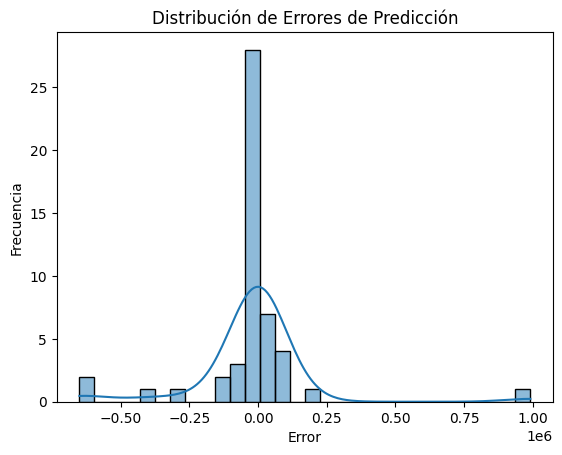

In [15]:
# ----------------------------------------------------------------------
# Evaluación del desempeño predictivo de los modelos
# ----------------------------------------------------------------------

# Diccionario para almacenar los resultados de RMSE
results = {}

# Evaluar cada modelo
for name, model in models.items():
    if "Polynomial" in name:
        # Extraer el grado del polinomio de la cadena de nombre del modelo usando expresión regular
        degree = int(re.search(r'\d+', name.split('=')[-1]).group())  # Extrae el número
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Ajustar el modelo de regresión lineal con las características polinómicas
        linear_poly = LinearRegression()
        linear_poly.fit(X_train_poly, y_train)
        y_pred = linear_poly.predict(X_test_poly)

        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse
    else:
        # Para otros modelos
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse

# Mostrar los resultados de RMSE para cada modelo
print("\nResultados de RMSE para cada modelo:")
for model, error in results.items():
    print(f"{model}: RMSE = {error:.2f}")

# Mejor modelo y errores
best_model_name = min(results, key=results.get)
print(f"\nMejor modelo: {best_model_name}")

# Calcular errores de predicción para el mejor modelo
if "Polynomial" in best_model_name:
    degree = int(re.search(r'\d+', best_model_name.split('=')[-1]).group())  # Extraer grado
    poly = PolynomialFeatures(degree=degree)
    X_test_poly = poly.transform(X_test)
    errors = y_test - linear_poly.predict(X_test_poly)
else:
    errors = y_test - models[best_model_name].predict(X_test)

# Visualización de errores
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribución de Errores de Predicción')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [11]:
# ----------------------------------------------------------------------
# Validación Cruzada K-Fold
# ----------------------------------------------------------------------

# Número de pliegues
k_folds = 5

# Diccionario para almacenar los resultados de la validación cruzada
cv_results = {}

# Evaluar cada modelo usando validación cruzada K-Fold
for name, model in models.items():
    if "Polynomial" in name:
        # Extraer el grado del polinomio de la cadena de nombre del modelo usando expresión regular
        degree = int(re.search(r'\d+', name.split('=')[-1]).group())  # Extrae el número
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)  # Transformar todas las características de X

        # Realizar la validación cruzada K-Fold
        cv_scores = cross_val_score(LinearRegression(), X_poly, y, cv=k_folds, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(-cv_scores.mean())  # Calcular RMSE promedio de K-Fold
        cv_results[name] = rmse_cv
    else:
        # Para otros modelos
        cv_scores = cross_val_score(model, X, y, cv=k_folds, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(-cv_scores.mean())  # Calcular RMSE promedio de K-Fold
        cv_results[name] = rmse_cv

# Mostrar los resultados de RMSE promedio para cada modelo con validación cruzada
print("\nResultados de RMSE (K-Fold) para cada modelo:")
for model, error in cv_results.items():
    print(f"{model}: RMSE (K-Fold) = {error:.2f}")

# Mejor modelo basado en K-Fold
best_model_name_cv = min(cv_results, key=cv_results.get)
print(f"\nMejor modelo basado en K-Fold: {best_model_name_cv}")

# Comparar el RMSE de la validación cruzada con el RMSE obtenido en el conjunto de prueba:
print("\nComparación RMSE (Conjunto de prueba vs. K-Fold):")
print(f"{best_model_name_cv} - RMSE en conjunto de prueba: {results[best_model_name_cv]:.2f}")
print(f"{best_model_name_cv} - RMSE en K-Fold: {cv_results[best_model_name_cv]:.2f}")


Resultados de RMSE (K-Fold) para cada modelo:
Linear Regression: RMSE (K-Fold) = 17882772.30
Polynomial Regression (degree=2): RMSE (K-Fold) = 235941.00
Polynomial Regression (degree=3): RMSE (K-Fold) = 4261644.79
Decision Tree (max_depth=5): RMSE (K-Fold) = 443884.89
Decision Tree (max_depth=10): RMSE (K-Fold) = 425303.15
Random Forest (n_estimators=50): RMSE (K-Fold) = 485165.91
Random Forest (n_estimators=100): RMSE (K-Fold) = 484560.91
Gradient Boosting: RMSE (K-Fold) = 478851.04
Support Vector Machine (RBF): RMSE (K-Fold) = 1195754.67
K-Nearest Neighbors (n_neighbors=5): RMSE (K-Fold) = 537383.80

Mejor modelo basado en K-Fold: Polynomial Regression (degree=2)

Comparación RMSE (Conjunto de prueba vs. K-Fold):
Polynomial Regression (degree=2) - RMSE en conjunto de prueba: 292376.06
Polynomial Regression (degree=2) - RMSE en K-Fold: 235941.00
